# Large-scale models and simulation methods
## Course Project, Spring 2024

Authors: \
Elijah JOUVENOT elijah.jouvenot@edu.univ-eiffel.fr \
William SOM william.som@edu.univ-eiffel.fr

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import numpy.linalg as la
import shapely.geometry as sgeo
import osmnx as ox
import networkx as nx

In [2]:
data_folder = "./data/"

## Exercise 1.1: Study area (2 points)

In [3]:
columns = {
    "IRIS": str,
    "IPONDI": float,
    "AGED": int,
    "CS1": int
}

df_census = pd.read_csv(data_folder + "FD_INDCVI_2019.csv", sep = ";", dtype = columns, usecols = columns.keys())
df_census.head()

AGED  CS1    IPONDI       IRIS
0    68    7  3.324481  010040101
1    33    6  2.957422  010040202
2     1    8  2.957422  010040202
3    30    6  2.957422  010040202
4    72    7  5.046771  ZZZZZZZZZ

In [4]:
df_census = df_census.rename(columns = {
    "IRIS": "iris_id",
    "IPONDI": "weight",
    "AGED": "age",
    "CS1": "csp"
})

df_census.head()

age  csp    weight    iris_id
0   68    7  3.324481  010040101
1   33    6  2.957422  010040202
2    1    8  2.957422  010040202
3   30    6  2.957422  010040202
4   72    7  5.046771  ZZZZZZZZZ

In [5]:
# We keep the municipalities with over 10,000 inhabitants.

df_census["department_id"] = df_census["iris_id"].str[:2]
df_census["municipality_id"] = df_census["iris_id"].str[:5]

inhabitants_per_municipality = df_census.groupby("municipality_id")["weight"].sum().reset_index()
big_municipalities = inhabitants_per_municipality[
    inhabitants_per_municipality["weight"] > 10000
]

big_municipalities

municipality_id        weight
0              01004  1.414600e+04
1              01033  1.641331e+04
3              01053  4.112293e+04
5              01160  1.001750e+04
6              01173  1.312100e+04
...              ...           ...
1911           97416  8.499553e+04
1913           97418  3.406500e+04
1915           97420  2.406494e+04
1917           97422  7.982240e+04
1920           ZZZZZ  2.708098e+07

[1044 rows x 2 columns]

In [6]:
# Now we need to filter the municipalities that have at least 2 neighbouring municipalities with a direct border. 
# To do so, we will plot all the municipalities with more than 10,000 inhabitants and check for the ones that fill the condition. 

df_iris = gpd.read_file(data_folder + "CONTOURS-IRIS.shp")
df_iris = df_iris.rename(columns = {
    "INSEE_COM": "municipality_id",
    "CODE_IRIS": "iris_id",
})[["iris_id", "municipality_id", "geometry"]]

df_iris

iris_id municipality_id  \
0      721910000           72191   
1      772480000           77248   
2      514260000           51426   
3      811990000           81199   
4      592250102           59225   
...          ...             ...   
48584  710730102           71073   
48585  385450101           38545   
48586  740630000           74063   
48587  951010000           95101   
48588  384030000           38403   

                                                geometry  
0      POLYGON ((498083.500 6747517.400, 498128.000 6...  
1      POLYGON ((685753.100 6868612.900, 685757.700 6...  
2      POLYGON ((759067.200 6849592.700, 758778.600 6...  
3      POLYGON ((651482.800 6326359.400, 651475.600 6...  
4      POLYGON ((767673.500 7022290.500, 767647.200 7...  
...                                                  ...  
48584  POLYGON ((831995.400 6646411.800, 831977.700 6...  
48585  POLYGON ((912429.500 6439712.700, 912342.600 6...  
48586  POLYGON ((991081.900 6580596.800, 991205.600 6...  
48587  POLYGON ((603615.500 6895980.900, 603612.300 6...  
48588  POLYGON ((914830.900 6422198.700, 914914.300 6...  

[48589 rows x 3 columns]

In [7]:
# Below are only plotted the municipalities with more than 10,000 inhabitants in France

df_municipalities = df_iris.dissolve("municipality_id").reset_index()

big_municipalities_geo = df_municipalities[
    df_municipalities["municipality_id"].isin(big_municipalities['municipality_id'])
]

big_municipalities_geo.plot()

<Axes: >

In [8]:
# Now we will try to find the municipalities that have at least 2 neighbours that also have more than 10,000 inhabitants each.

In [9]:
big_municipalities_geo.head()

municipality_id                                           geometry  \
2             01004  POLYGON ((882936.400 6541364.300, 882932.900 6...   
29            01033  POLYGON ((917099.800 6557074.200, 916882.400 6...   
48            01053  POLYGON ((871161.000 6568221.000, 870803.900 6...   
140           01160  POLYGON ((939230.900 6575856.600, 939165.200 6...   
149           01173  POLYGON ((935428.200 6585561.500, 935419.600 6...   

       iris_id  
2    010040102  
29   010330102  
48   010530402  
140  011600102  
149  011730103

In [10]:
# Find intersections between polygons, and exclude intersections with the same polygon
intersections = gpd.sjoin(big_municipalities_geo, big_municipalities_geo, how="inner", op="intersects", predicate="intersects", lsuffix='left', rsuffix='right')
# Filter intersections where polygon id are different
intersections = intersections[intersections['municipality_id_left'] != intersections['municipality_id_right']]

intersections.head()

/Users/william/miniforge3/envs/lsm/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


municipality_id_left                                           geometry  \
212                  01249  POLYGON ((852827.400 6525131.900, 852663.900 6...   
27245                69271  POLYGON ((850578.000 6516089.300, 850569.400 6...   
27248                69275  POLYGON ((852005.600 6518562.400, 851687.000 6...   
27250                69277  POLYGON ((858393.800 6515939.400, 858344.600 6...   
212                  01249  POLYGON ((852827.400 6525131.900, 852663.900 6...   

      iris_id_left  index_right municipality_id_right iris_id_right  
212      012490102        27255                 69282     692820201  
27245    692710104        27255                 69282     692820201  
27248    692750107        27255                 69282     692820201  
27250    692770103        27255                 69282     692820201  
212      012490102        27259                 69286     692860202

In [11]:
# Count the number of neighbours for each polygon
neighbors_count = intersections.groupby("municipality_id_left").size()
neighbors_count

municipality_id_left
01249    4
03095    1
03190    1
03310    1
03321    1
        ..
95585    7
95598    4
95607    2
95637    2
95680    3
Length: 721, dtype: int64

In [12]:
# Filter polygons which have at least two neighbours
polygones_adjacents = big_municipalities_geo[big_municipalities_geo.municipality_id.isin(neighbors_count[neighbors_count >= 2].index)]

In [13]:
print(polygones_adjacents)

      municipality_id                                           geometry  \
212             01249  POLYGON ((852827.400 6525131.900, 852663.900 6...   
1873            06004  POLYGON ((1031471.400 6283144.200, 1031470.600...   
1896            06027  POLYGON ((1034157.100 6291563.000, 1034137.300...   
1898            06029  POLYGON ((1020982.900 6279909.100, 1020846.900...   
1899            06030  POLYGON ((1021086.300 6282758.400, 1021191.700...   
...               ...                                                ...   
34852           95585  POLYGON ((654277.500 6874864.400, 654063.500 6...   
34855           95598  POLYGON ((649441.500 6876516.300, 649412.900 6...   
34857           95607  POLYGON ((641906.800 6878801.000, 641869.200 6...   
34865           95637  POLYGON ((629402.600 6880674.300, 629248.100 6...   
34875           95680  POLYGON ((656141.900 6877322.900, 656091.200 6...   

         iris_id  
212    012490102  
1873   060040108  
1896   060270103  
1898   0602

<Axes: >

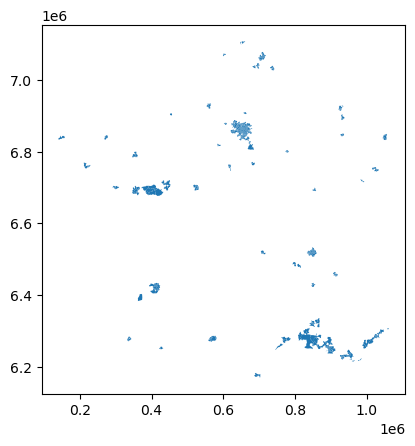

In [14]:
polygones_adjacents.plot()

In [15]:
municipality_id_specified = "28085"

In [16]:
selected_muni = intersections[intersections['municipality_id_left'] == municipality_id_specified]
selected_muni

municipality_id_left                                           geometry  \
9998                28085  POLYGON ((589848.200 6815494.000, 589762.200 6...   
9998                28085  POLYGON ((589848.200 6815494.000, 589762.200 6...   

     iris_id_left  index_right municipality_id_right iris_id_right  
9998    280850301        10112                 28218     282180301  
9998    280850301        10121                 28229     282290202

<Axes: >

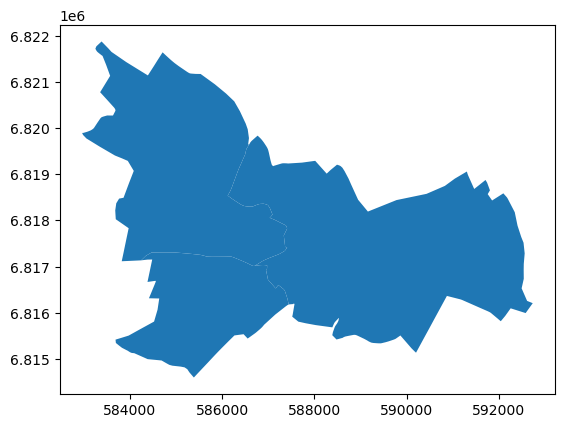

In [17]:
adjacent_polygons = big_municipalities_geo[big_municipalities_geo['municipality_id'].isin(selected_muni['municipality_id_right']) | big_municipalities_geo['municipality_id'].isin(selected_muni['municipality_id_left'])]

adjacent_polygons.plot()

## Explain which centre municipality you have chosen and where it is located (department and region) (1 point)

In [18]:
# The municipality 28085 corresponds to the "commune de Chartres"
# - department -> Eure-et-Loir (28)
# - region -> Centre-Val de Loire

## Prepare a map (1 point)
- that shows the department in which the municipality is located
- that shows all municipalities in the department
- that highlights the “study area”, i.e., the selected municipality and all neighbouring municipalities
- that highlights the selected municipality


In [19]:
department = df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])].plot()
#Selected municipalities
muni_iris = big_municipalities_geo[big_municipalities_geo['municipality_id'].isin(selected_muni['municipality_id_left'])]
#Neighbour
big_adjacent_municipalities = big_municipalities_geo[big_municipalities_geo['municipality_id'].isin(selected_muni['municipality_id_right'])]
adjacent_municipalities = df_iris[df_iris.touches(big_municipalities_geo[big_municipalities_geo['municipality_id'].isin(selected_muni['municipality_id_left'])].unary_union)]

muni_iris.plot(ax=department, color='red')
adjacent_municipalities.plot(ax=department, color='yellow')
big_adjacent_municipalities.plot(ax=department, color='orange')

plt.show()

## Exercise 1.2: Territorial analysis I (3 points)

In [20]:
# Build study area

study_area_df_iris = pd.concat([muni_iris, adjacent_municipalities])
study_area_df_iris

municipality_id                                           geometry  \
9998            28085  POLYGON ((589848.200 6815494.000, 589762.200 6...   
6101            28278  POLYGON ((597228.100 6819620.200, 597231.600 6...   
7913            28218  POLYGON ((586697.600 6816043.500, 586700.700 6...   
9089            28209  POLYGON ((588563.100 6819180.100, 588546.900 6...   
9983            28173  POLYGON ((590834.700 6820423.500, 590851.100 6...   
10108           28220  POLYGON ((587745.700 6814041.100, 587756.800 6...   
18020           28110  POLYGON ((589952.200 6812612.100, 589942.300 6...   
22287           28218  POLYGON ((586708.800 6817016.800, 586829.200 6...   
33314           28177  POLYGON ((589952.200 6812612.100, 589975.800 6...   
35496           28229  POLYGON ((587095.600 6818122.800, 587085.700 6...   
39573           28229  POLYGON ((586433.000 6817652.700, 586437.800 6...   
40124           28229  POLYGON ((586433.000 6817652.700, 586432.600 6...   
40452           28070  POLYGON ((588563.100 6819180.100, 588562.700 6...   
41594           28220  POLYGON ((586551.800 6815438.000, 586561.900 6...   
46308           28218  POLYGON ((585574.500 6816218.300, 585559.700 6...   

         iris_id  
9998   280850301  
6101   282780000  
7913   282180102  
9089   282090000  
9983   281730000  
10108  282200103  
18020  281100000  
22287  282180401  
33314  281770000  
35496  282290102  
39573  282290101  
40124  282290301  
40452  280700000  
41594  282200101  
46308  282180201

In [21]:
muni_census = df_census[df_census['municipality_id'] == municipality_id_specified]
neighbour =  df_census[df_census["municipality_id"].isin(df_iris[df_iris.touches(df_iris[df_iris["municipality_id"] == municipality_id_specified].unary_union)].municipality_id)]
study_area_df_census = pd.concat([muni_census, neighbour])
study_area_df_census

age  csp    weight    iris_id department_id municipality_id
3460097   41    3  2.751932  280850703            28           28085
3460098   32    3  2.751932  280850703            28           28085
3460099    5    8  2.751932  280850703            28           28085
3460100   28    3  3.070388  280850302            28           28085
3460101   21    5  2.554056  280850401            28           28085
...      ...  ...       ...        ...           ...             ...
3440415   18    8  5.000065  282180102            28           28218
3440416   54    8  5.000065  282180102            28           28218
3440417   58    7  5.000065  282180102            28           28218
3440418   56    1  5.000065  282180102            28           28218
3440419   38    4  5.000065  282180102            28           28218

[26117 rows x 6 columns]

In [22]:
study_area_df_iris = pd.concat([muni_iris, adjacent_municipalities])
study_area_df_iris

municipality_id                                           geometry  \
9998            28085  POLYGON ((589848.200 6815494.000, 589762.200 6...   
6101            28278  POLYGON ((597228.100 6819620.200, 597231.600 6...   
7913            28218  POLYGON ((586697.600 6816043.500, 586700.700 6...   
9089            28209  POLYGON ((588563.100 6819180.100, 588546.900 6...   
9983            28173  POLYGON ((590834.700 6820423.500, 590851.100 6...   
10108           28220  POLYGON ((587745.700 6814041.100, 587756.800 6...   
18020           28110  POLYGON ((589952.200 6812612.100, 589942.300 6...   
22287           28218  POLYGON ((586708.800 6817016.800, 586829.200 6...   
33314           28177  POLYGON ((589952.200 6812612.100, 589975.800 6...   
35496           28229  POLYGON ((587095.600 6818122.800, 587085.700 6...   
39573           28229  POLYGON ((586433.000 6817652.700, 586437.800 6...   
40124           28229  POLYGON ((586433.000 6817652.700, 586432.600 6...   
40452           28070  POLYGON ((588563.100 6819180.100, 588562.700 6...   
41594           28220  POLYGON ((586551.800 6815438.000, 586561.900 6...   
46308           28218  POLYGON ((585574.500 6816218.300, 585559.700 6...   

         iris_id  
9998   280850301  
6101   282780000  
7913   282180102  
9089   282090000  
9983   281730000  
10108  282200103  
18020  281100000  
22287  282180401  
33314  281770000  
35496  282290102  
39573  282290101  
40124  282290301  
40452  280700000  
41594  282200101  
46308  282180201

In [23]:
muni_census = df_census[df_census['municipality_id'] == municipality_id_specified]
neighbour =  df_census[df_census["municipality_id"].isin(df_iris[df_iris.touches(df_iris[df_iris["municipality_id"] == municipality_id_specified].unary_union)].municipality_id)]
study_area_df_census = pd.concat([muni_census, neighbour])
study_area_df_census

age  csp    weight    iris_id department_id municipality_id
3460097   41    3  2.751932  280850703            28           28085
3460098   32    3  2.751932  280850703            28           28085
3460099    5    8  2.751932  280850703            28           28085
3460100   28    3  3.070388  280850302            28           28085
3460101   21    5  2.554056  280850401            28           28085
...      ...  ...       ...        ...           ...             ...
3440415   18    8  5.000065  282180102            28           28218
3440416   54    8  5.000065  282180102            28           28218
3440417   58    7  5.000065  282180102            28           28218
3440418   56    1  5.000065  282180102            28           28218
3440419   38    4  5.000065  282180102            28           28218

[26117 rows x 6 columns]

#### Provide a list of INSEE municipality identifiers for all the municipalities included in the study area. In a table, provide the number of samples (data points) in the [INSEE CENSUS] for each municipality along with the weighted population count (including zero). (1 point)

In [24]:
pd.merge(study_area_df_iris["municipality_id"], study_area_df_census.groupby('municipality_id').agg(weighted_population=('weight', 'sum'), nb_of_samples=('municipality_id', 'count')).reset_index(), how='left', on='municipality_id')

municipality_id  weighted_population  nb_of_samples
0            28085         38520.000055        14536.0
1            28278                  NaN            NaN
2            28218         15403.000000         5992.0
3            28209                  NaN            NaN
4            28173                  NaN            NaN
5            28220          6710.684624         1339.0
6            28110                  NaN            NaN
7            28218         15403.000000         5992.0
8            28177                  NaN            NaN
9            28229         11122.000168         4250.0
10           28229         11122.000168         4250.0
11           28229         11122.000168         4250.0
12           28070                  NaN            NaN
13           28220          6710.684624         1339.0
14           28218         15403.000000         5992.0

#### Plot the age distribution of the study area and at least three municipalities in the study area, and report whether you see any differences or not. (1 point)

In [25]:
df_age = study_area_df_census.groupby("age").size().reset_index(name = "count")
df_age.head()

age  count
0    0     17
1    1    278
2    2    303
3    3    337
4    4    305

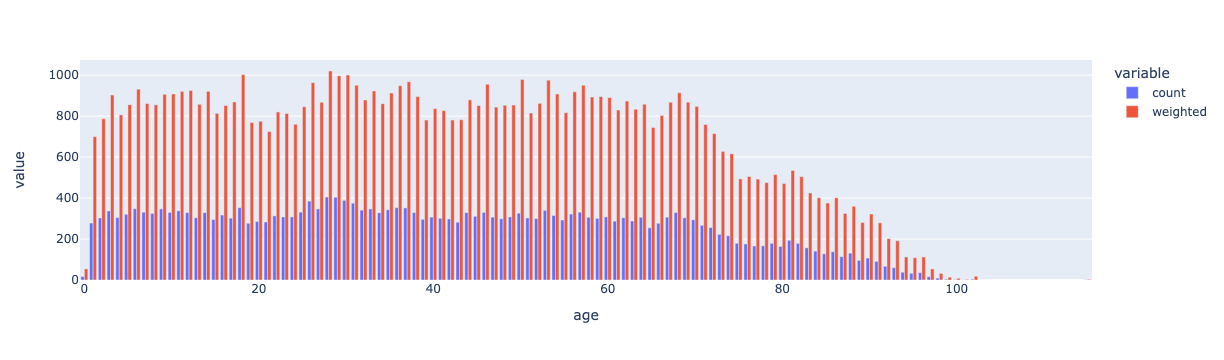

In [26]:
df_age_weighted = study_area_df_census.groupby("age")["weight"].sum().reset_index(name = "weighted")
df_age_weighted.head()

df_comparison = pd.merge(df_age, df_age_weighted, on = "age")

px.bar(df_comparison, x = "age", y = ["count", "weighted"], barmode = "group")

In [27]:
df_age_study_area = study_area_df_census.groupby("age")["weight"].sum().reset_index(name="people")

hist = px.bar(df_age_study_area, x="age", y="people", title="Age distribution of the study area")

hist.show()

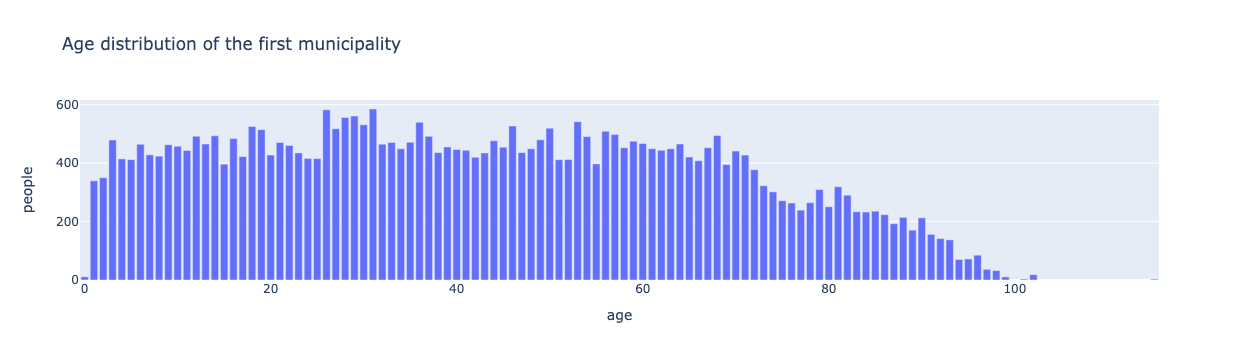

In [28]:
first_muni = study_area_df_census[study_area_df_census['municipality_id'] == municipality_id_specified]

df_age_study_area = first_muni.groupby("age")["weight"].sum().reset_index(name="people")

hist = px.bar(df_age_study_area, x="age", y="people", title="Age distribution of the first municipality")

hist.show()

In [29]:
second_muni = study_area_df_census[study_area_df_census['municipality_id'] == "28218"]

df_age_study_area = second_muni.groupby("age")["weight"].sum().reset_index(name="people")

hist = px.bar(df_age_study_area, x="age", y="people", title="Age distribution of the second municipality")

hist.show()

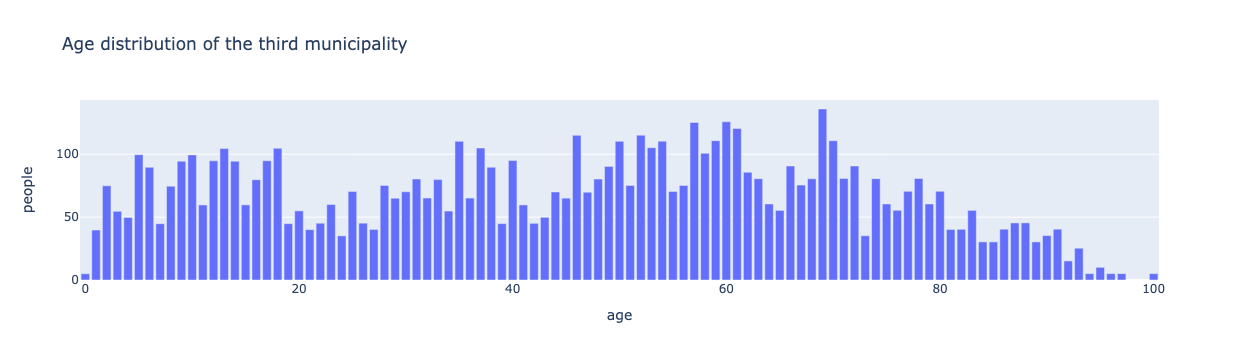

In [30]:
third_muni = study_area_df_census[study_area_df_census['municipality_id'] == "28220"]

df_age_study_area = third_muni.groupby("age")["weight"].sum().reset_index(name="people")

hist = px.bar(df_age_study_area, x="age", y="people", title="Age distribution of the third municipality")

hist.show()

In [31]:
# We can see that the age distribution of the study area looks a lot like the age distribution of the first municipality, which is 28085 Chartres.
# It is logical due to the fact that this muncipality counts most of the population the study area.
# The shape of the histogram of the third municipality does not look like the one of the study area because it counts less than 10,000 inhabitants 
# so it has less impacts that the other municipalities with over 10,000 inhabitants.

#### Plot the distribution of social-professional categories of the study area and of at least three municipalities in the study area, and report whether you see any differences. (1 point)

In [32]:
dico = {
    1: "Agriculteurs",
    2: "Artisans",
    3: "Cadres",
    4: "Intermédiaires",
    5: "Employés",
    6: "Ouvriers",
    7: "Retraités",
    8: "Autres"
}

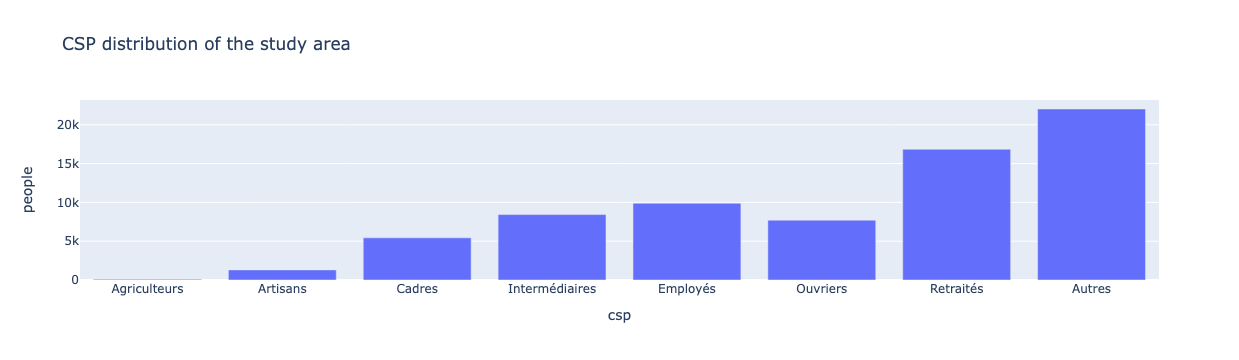

In [33]:
df_csp_study_area = study_area_df_census.groupby("csp")["weight"].sum().reset_index(name="people")
df_csp_study_area["csp"] = df_csp_study_area["csp"].replace(dico)

hist = px.bar(df_csp_study_area, x="csp", y="people", title="CSP distribution of the study area")

hist.show()

In [34]:
first_muni = study_area_df_census[study_area_df_census['municipality_id'] == municipality_id_specified]

df_csp_study_area = first_muni.groupby("csp")["weight"].sum().reset_index(name="people")
df_csp_study_area["csp"] = df_csp_study_area["csp"].replace(dico)

hist = px.bar(df_csp_study_area, x="csp", y="people", title="CSP distribution of the first municipality")

hist.show()

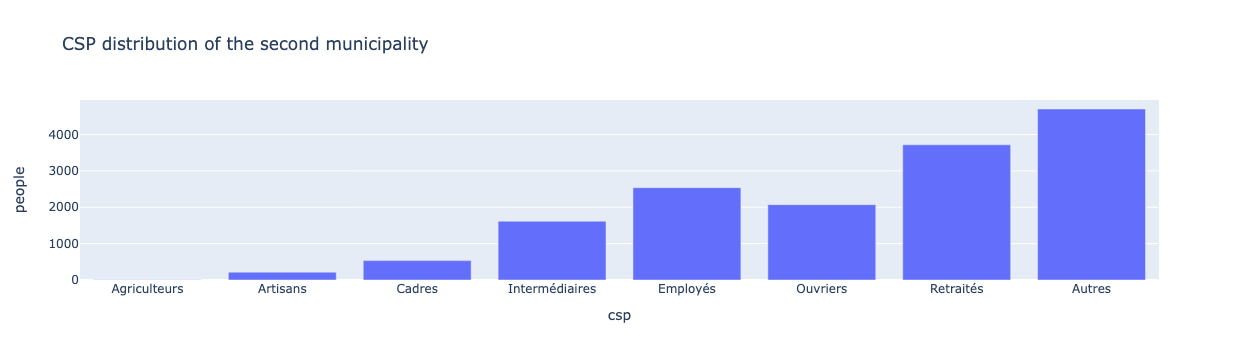

In [35]:
second_muni = study_area_df_census[study_area_df_census['municipality_id'] == "28218"]

df_csp_study_area = second_muni.groupby("csp")["weight"].sum().reset_index(name="people")
df_csp_study_area["csp"] = df_csp_study_area["csp"].replace(dico)

hist = px.bar(df_csp_study_area, x="csp", y="people", title="CSP distribution of the second municipality")

hist.show()

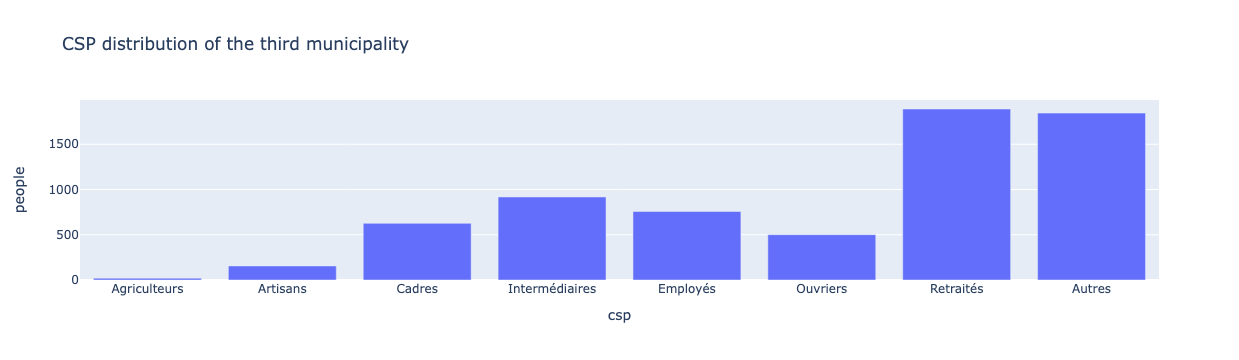

In [36]:
third_muni = study_area_df_census[study_area_df_census['municipality_id'] == "28220"]

df_csp_study_area = third_muni.groupby("csp")["weight"].sum().reset_index(name="people")
df_csp_study_area["csp"] = df_csp_study_area["csp"].replace(dico)

hist = px.bar(df_csp_study_area, x="csp", y="people", title="CSP distribution of the third municipality")

hist.show()

In [37]:
# The 2nd municipality has a smaller proportion of cadres and more ouvriers and employés than the other municipalities.

## Exercise 1.3: Territorial analysis II (3 points)

In [38]:
columns = ["COM", "C19_POP15P"]
columns += ["C19_POP15P_CS{}".format(k) for k in range(1, 9)]

df_population = pd.read_csv(data_folder + "base-ic-evol-struct-pop-2019.CSV", sep = ";", usecols = columns, dtype = {
     "COM": str   
})

renamed_columns = ["municipality_id", "population"]
renamed_columns += ["csp_{}".format(k) for k in range(1, 9)]

df_population.columns = renamed_columns

df_population = df_population.groupby("municipality_id").sum().reset_index()
df_population

municipality_id    population        csp_1        csp_2        csp_3  \
0               01001    619.406049    15.565978    19.822632    76.142088   
1               01002    205.408895     0.000000    21.265503    15.927908   
2               01004  11508.832532     2.762881   327.166403   784.225660   
3               01005   1390.384400     4.913019   112.999439   112.999439   
4               01006     91.636364     0.000000     0.000000     5.090909   
...               ...           ...          ...          ...          ...   
34985           97420  18357.493396   132.645899   600.979456   760.699348   
34986           97421   5395.000000   205.000000   145.000000    60.000000   
34987           97422  61865.447815  1105.911121  2429.827432  2229.743854   
34988           97423   5578.591701    60.509132   156.315256   196.654677   
34989           97424   4325.730842    42.275545   127.181990    67.636782   

             csp_4         csp_5        csp_6         csp_7         csp_8  
0        98.357964    100.516361   126.843164    152.541469     29.616393  
1        26.460181     42.135589    10.596822     67.296631     21.726261  
2      1890.243930   1891.133347  2001.750487   2763.422684   1848.127141  
3       221.085859    294.781145   186.694725    338.998316    117.912458  
4        25.454545     15.272727    15.272727     25.454545      5.090909  
...            ...           ...          ...           ...           ...  
34985  2486.081710   3999.997623  2624.710721   2440.443091   5311.935549  
34986   345.000000    920.000000  1135.000000    660.000000   1925.000000  
34987  7022.017452  12993.475117  8175.812588  10539.247496  17369.412753  
34988   579.879177   1356.413032  1025.279554    675.685302   1527.855571  
34989   281.181830    939.925428   931.145285    731.173870   1205.210112  

[34990 rows x 10 columns]

In [39]:
study_area_df_population = df_population[df_population["municipality_id"].isin(study_area_df_iris["municipality_id"])].reset_index(drop=True)

In [40]:
study_area_df_population

municipality_id    population      csp_1       csp_2        csp_3  \
0           28070   2966.488330   4.963811   45.617511   293.975029   
1           28085  32004.085445  61.455663  767.719844  3575.409814   
2           28110   3276.141112   0.000000   43.238876   431.477250   
3           28173   1207.536571  10.123911   61.365311   134.867760   
4           28177    522.908513  10.086134    5.024488    30.091530   
5           28209   4540.304887   0.000000  120.938394   488.792676   
6           28218  12528.595777   7.810856  215.456539   533.032374   
7           28220   5580.782426  20.062861  155.418605   626.005713   
8           28229   8679.676162  10.807806  164.354200   698.052594   
9           28278   1248.054098  10.093546   40.040995   105.854699   

         csp_4        csp_5        csp_6        csp_7        csp_8  
0   620.451451   405.696503   320.720028   801.438340   473.625657  
1  4638.895910  5039.420821  3709.700067  9134.975008  5076.508317  
2   658.820051   598.122319   350.930441   787.410501   406.141673  
3   191.530444   160.527561   113.976868   423.344800   111.799915  
4    95.762945    50.282240   115.881816   135.050720    80.728639  
5   745.786763   700.395766   526.587603  1245.687665   712.116020  
6  1614.482616  2533.311706  2072.046550  3718.426362  1834.028774  
7   917.372331   756.975838   501.113224  1889.575332   714.258523  
8  1259.331092  1555.448536  1429.769370  2104.426510  1457.486054  
9   221.166083   181.098029   110.722569   448.502004   130.576172

#### Make use of the aggregated census data [INSEE AGGREGATED] to create a bar plot indicating the number of inhabitants in each municipality of the study area. Also, provide this information on a map. (1 point)

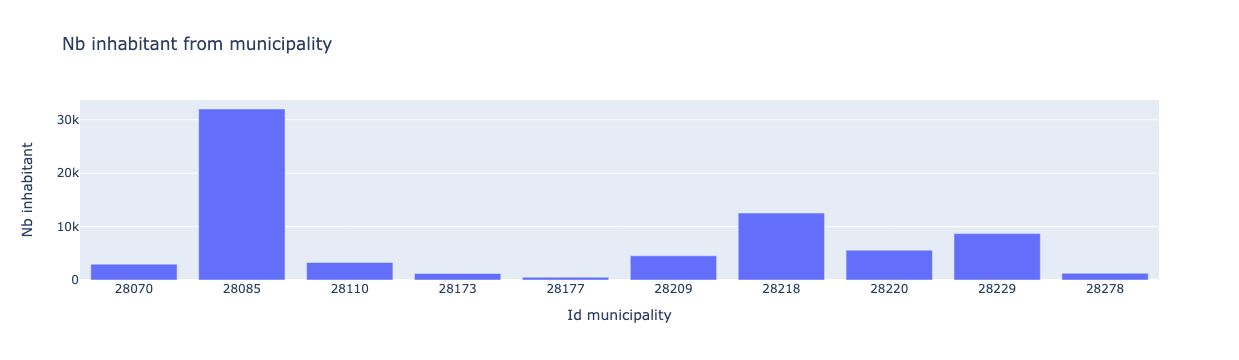

In [41]:
hist = px.bar(study_area_df_population, x="municipality_id", y="population", title="Nb inhabitant from municipality", labels={'municipality_id': 'Id municipality', 'population': 'Nb inhabitant'})

hist.show()

In [42]:
popu_plot = pd.merge(df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])], study_area_df_population, on = "municipality_id")

In [43]:
municipalites_annotées = {}

ax = popu_plot.plot(column="population", cmap="viridis", legend=True)

for idx, row in popu_plot.iterrows():
    municipality_id = row["municipality_id"]
    if municipality_id not in municipalites_annotées:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, municipality_id, fontsize=8, ha='center', va='center', color='black', alpha=0.7)
        municipalites_annotées[municipality_id] = True
    
plt.show()

#### Make use of the URSSAF employment data [URSSAF] to create a bar plot indicating the number of employees in each municipality of the study area. Also, provide this information on a map. (1 point)

In [44]:
columns = ["Code commune", "Effectifs salariés 2019"]

df_employees = pd.read_csv(data_folder + "etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv", sep = ";", usecols = columns, dtype = { "Code commune": str })

renamed_columns = ["municipality_id", "employees"]

df_employees.columns = renamed_columns

df_employees = df_employees.groupby("municipality_id").sum().reset_index()
df_employees

municipality_id  employees
0               01001       29.0
1               01002        2.0
2               01004     4859.0
3               01005      115.0
4               01007      302.0
...               ...        ...
33570           97420     2976.0
33571           97421      351.0
33572           97422     7434.0
33573           97423      348.0
33574           97424      414.0

[33575 rows x 2 columns]

In [45]:
study_area_df_employees = df_employees[df_employees["municipality_id"].isin(study_area_df_iris["municipality_id"])]

In [46]:
study_area_df_employees

municipality_id  employees
9465           28070      366.0
9479           28085    20107.0
9501           28110     1485.0
9554           28173      411.0
9557           28177     2075.0
9583           28209     1003.0
9592           28218     3965.0
9594           28220     1653.0
9601           28229     2341.0
9640           28278     1144.0

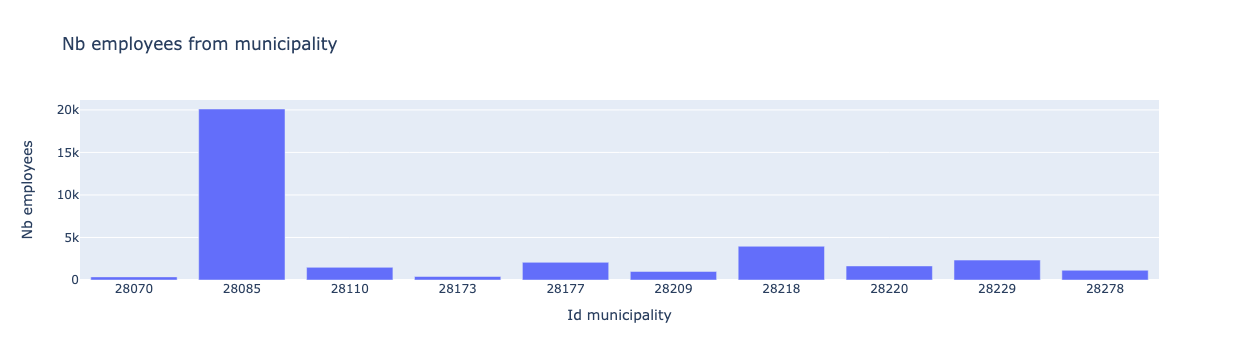

In [47]:
hist = px.bar(study_area_df_employees, x="municipality_id", y="employees", title="Nb employees from municipality", labels={'municipality_id': 'Id municipality', 'employees': 'Nb employees'})

hist.show()

In [48]:
employ_plot = pd.merge(df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])], study_area_df_employees, on = "municipality_id")

In [49]:
municipalites_annotées = {}

ax = employ_plot.plot(column="employees", cmap="viridis", legend=True)

for idx, row in employ_plot.iterrows():
    municipality_id = row["municipality_id"]
    if municipality_id not in municipalites_annotées:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, municipality_id, fontsize=8, ha='center', va='center', color='black', alpha=0.7)
        municipalites_annotées[municipality_id] = True
    
plt.show()

#### Report the total number of inhabitants of the study area and the total number of employees in the study area (1 point)

In [50]:
print("Number of inhabitants of the study area: " + str(study_area_df_population["population"].sum()))
print("Number of employees of the study area: " + str(study_area_df_employees["employees"].sum()))

Number of inhabitants of the study area: 72554.57332015377
Number of employees of the study area: 34550.0


## Exercise 2.1: Trip production (2 points)

In [51]:
study_area_df_population

municipality_id    population      csp_1       csp_2        csp_3  \
0           28070   2966.488330   4.963811   45.617511   293.975029   
1           28085  32004.085445  61.455663  767.719844  3575.409814   
2           28110   3276.141112   0.000000   43.238876   431.477250   
3           28173   1207.536571  10.123911   61.365311   134.867760   
4           28177    522.908513  10.086134    5.024488    30.091530   
5           28209   4540.304887   0.000000  120.938394   488.792676   
6           28218  12528.595777   7.810856  215.456539   533.032374   
7           28220   5580.782426  20.062861  155.418605   626.005713   
8           28229   8679.676162  10.807806  164.354200   698.052594   
9           28278   1248.054098  10.093546   40.040995   105.854699   

         csp_4        csp_5        csp_6        csp_7        csp_8  
0   620.451451   405.696503   320.720028   801.438340   473.625657  
1  4638.895910  5039.420821  3709.700067  9134.975008  5076.508317  
2   658.820051   598.122319   350.930441   787.410501   406.141673  
3   191.530444   160.527561   113.976868   423.344800   111.799915  
4    95.762945    50.282240   115.881816   135.050720    80.728639  
5   745.786763   700.395766   526.587603  1245.687665   712.116020  
6  1614.482616  2533.311706  2072.046550  3718.426362  1834.028774  
7   917.372331   756.975838   501.113224  1889.575332   714.258523  
8  1259.331092  1555.448536  1429.769370  2104.426510  1457.486054  
9   221.166083   181.098029   110.722569   448.502004   130.576172

#### Apply the model to your study area and solve the following tasks:

In [52]:
Beta = [27.244, 0.319, 0.994, 0.863, 0.990, 0.780, 0.708, 0.120, -0.073]
N = ["csp_1", "csp_2", "csp_3", "csp_4", "csp_5", "csp_6", "csp_7", "csp_8"]
study_area_df_population['originating_trips'] = study_area_df_population.apply(lambda row: max(Beta[0] + sum(bi * row[ni] for bi, ni in zip(Beta[1:], N)), 0), axis=1)
study_area_df_population

municipality_id    population      csp_1       csp_2        csp_3  \
0           28070   2966.488330   4.963811   45.617511   293.975029   
1           28085  32004.085445  61.455663  767.719844  3575.409814   
2           28110   3276.141112   0.000000   43.238876   431.477250   
3           28173   1207.536571  10.123911   61.365311   134.867760   
4           28177    522.908513  10.086134    5.024488    30.091530   
5           28209   4540.304887   0.000000  120.938394   488.792676   
6           28218  12528.595777   7.810856  215.456539   533.032374   
7           28220   5580.782426  20.062861  155.418605   626.005713   
8           28229   8679.676162  10.807806  164.354200   698.052594   
9           28278   1248.054098  10.093546   40.040995   105.854699   

         csp_4        csp_5        csp_6        csp_7        csp_8  \
0   620.451451   405.696503   320.720028   801.438340   473.625657   
1  4638.895910  5039.420821  3709.700067  9134.975008  5076.508317   
2   658.820051   598.122319   350.930441   787.410501   406.141673   
3   191.530444   160.527561   113.976868   423.344800   111.799915   
4    95.762945    50.282240   115.881816   135.050720    80.728639   
5   745.786763   700.395766   526.587603  1245.687665   712.116020   
6  1614.482616  2533.311706  2072.046550  3718.426362  1834.028774   
7   917.372331   756.975838   501.113224  1889.575332   714.258523   
8  1259.331092  1555.448536  1429.769370  2104.426510  1457.486054   
9   221.166083   181.098029   110.722569   448.502004   130.576172   

   originating_trips  
0        1547.229629  
1       15770.875284  
2        1874.655239  
3         646.023766  
4         287.807493  
5        2324.244509  
6        6057.563343  
7        2756.409168  
8        4414.878206  
9         644.507840

#### Report how many trips have been generated in total (1 point)

In [53]:
print("Number of trips have been generated in total: " + str(study_area_df_population["originating_trips"].sum()))

Number of trips have been generated in total: 36324.19447549504


#### Report using a plot how many trips have been generated for each municipality in the study area. Also, show this information on a map. (1 point)


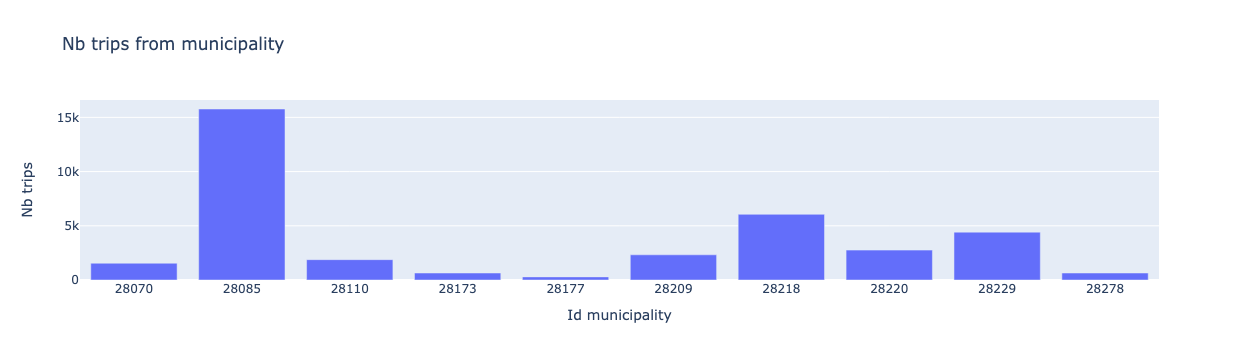

In [54]:
hist = px.bar(study_area_df_population, x="municipality_id", y="originating_trips", title="Nb trips from municipality", labels={'municipality_id': 'Id municipality', 'originating_trips': 'Nb trips'})

hist.show()

In [55]:
trips_plot = pd.merge(df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])], study_area_df_population, on = "municipality_id")

In [56]:
municipalites_annotées = {}

ax = trips_plot.plot(column="originating_trips", cmap="viridis", legend=True)

for idx, row in trips_plot.iterrows():
    municipality_id = row["municipality_id"]
    if municipality_id not in municipalites_annotées:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, municipality_id, fontsize=8, ha='center', va='center', color='black', alpha=0.7)
        municipalites_annotées[municipality_id] = True
    
plt.show()

## Exercise 2.2: Trip attraction (2 points)

In [57]:
sum_employement = study_area_df_employees['employees'].sum()

N_attraction = min(0.7 * sum_employement, 0.7 * study_area_df_population['originating_trips'].sum())

employement_per_zone = study_area_df_employees.set_index('municipality_id')['employees'].to_dict()

employement_per_zone

{'28070': 366.0,
 '28085': 20107.0,
 '28110': 1485.0,
 '28173': 411.0,
 '28177': 2075.0,
 '28209': 1003.0,
 '28218': 3965.0,
 '28220': 1653.0,
 '28229': 2341.0,
 '28278': 1144.0}

In [58]:
study_area_df_population['destination_trips'] = study_area_df_population.apply(lambda row: ( employement_per_zone[row['municipality_id']] / sum_employement) * N_attraction, axis=1)

#### Report using a plot how many arriving trips have been generated for each municipality in the study area. Also, show this information on a map. (2 points)

In [59]:
arriving_trips_plot = pd.merge(df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])], study_area_df_population, on = "municipality_id")

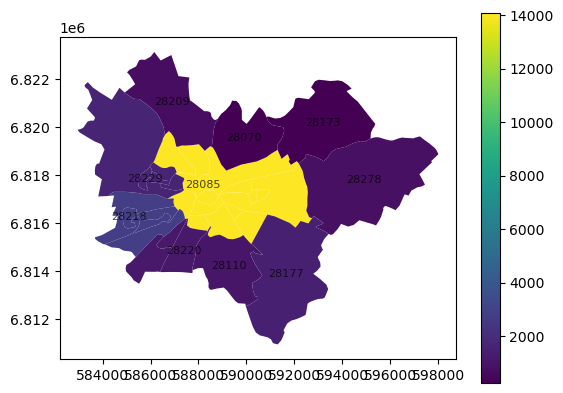

In [60]:
municipalites_annotées = {}

ax = arriving_trips_plot.plot(column="destination_trips", cmap="viridis", legend=True)

for idx, row in arriving_trips_plot.iterrows():
    municipality_id = row["municipality_id"]
    if municipality_id not in municipalites_annotées:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, municipality_id, fontsize=8, ha='center', va='center', color='black', alpha=0.7)
        municipalites_annotées[municipality_id] = True
    
plt.show()

#### In preparation for the next task, proportionately scale your demand per zone (Oi ) from Exercise 2.1 so that the total is the same as the number of trips N. In a balanced model, the number of originating flows must match the number of arriving flows over all zones. For that, scale your demand following:

In [61]:
study_area_df_population.head(1)['originating_trips']

sum_originating_trips = study_area_df_population['originating_trips'].sum()

sum_originating_trips

36324.19447549504

In [62]:
study_area_df_population['originating_trips_scaled'] = study_area_df_population.apply(lambda row: N_attraction * ( row['originating_trips'] / sum_originating_trips), axis=1)

## Exercise 2.3: Trip distribution (2 points)


#### Show the distance matrix as a table or in a plot. (1 point)

In [63]:
municipalities = study_area_df_population.shape[0]

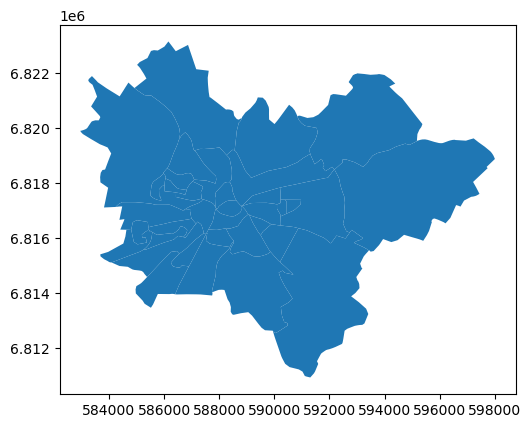

In [64]:
# We gather the all the polygons from the study area
study_area_polygons = pd.merge(df_iris[df_iris["municipality_id"].str.startswith(municipality_id_specified[:2])], study_area_df_population, on = "municipality_id")

study_area_polygons.plot()

plt.show()

In [65]:
# Here we fusion the polygons that have the same municipality_id to form only one polygon in order to calculate the centroids
study_area_df_iris_united = study_area_polygons.groupby('municipality_id')['geometry'].agg(lambda x: x.unary_union).reset_index()

study_area_df_iris_united['geometry'].plot()

plt.show()

In [66]:
# Calculate the distance matrix between the centroids of the municipalities

centroids = study_area_df_iris_united["geometry"].centroid
centroids = np.array([centroids.x, centroids.y] ).T

distance_matrix = np.zeros((municipalities, municipalities))

for k in range(municipalities):
    distance_matrix[k,:] = la.norm(centroids[k] - centroids, axis = 1)

In [67]:
plt.pcolor(distance_matrix)

#### Report the resulting flows $F_{ij}$ in a table or plot. (1 point)

In [68]:
alpha = -0.4
beta = -1.1e-4

In [69]:
# Verification with toy example

origins_verif = [3396, 5442, 43196, 5681]
dest_verif = [9462, 2294, 48377, 6621]

distance_matrix_verif = np.array([
    [0, 4066, 6595, 9462],
    [4066, 0, 4340, 10299],
    [6595, 4340, 0, 7287],
    [9462, 10299, 7287, 0]
])

friction_matrix_verif = np.exp(beta * distance_matrix_verif + alpha)

# Initialize production_i and attraction_j to 1
prod_verif = np.ones((4,))
attr_verif = np.ones((4,))

# Run the formulas iteratively until the values stabilize
for iteration in range(500):  
    for i in range(4):
        prod_verif[i] = origins_verif[i] / np.sum(attr_verif * friction_matrix_verif[i,:])
    
    for j in range(4):
        attr_verif[j] = dest_verif[j] / np.sum(prod_verif * friction_matrix_verif[:,j])

# Calculate the resulting flow
flow_matrix_verif = np.copy(friction_matrix_verif)

for i in range(4):
    flow_matrix_verif[i,:] *= origins_verif[i] / np.sum(attr_verif * friction_matrix_verif[i,:])

for j in range(4):
    flow_matrix_verif[:,j] *= dest_verif[j] / np.sum(prod_verif * friction_matrix_verif[:,j])

flow_matrix_verif = np.floor(flow_matrix_verif).astype(int)
df_flow_matrix_verif = pd.DataFrame(flow_matrix_verif, index=[1, 2, 3, 4], columns=[1, 2, 3, 4])
df_flow_matrix_verif["Σ"] = df_flow_matrix_verif.sum(axis=1)
df_flow_matrix_verif.loc["Σ"] = df_flow_matrix_verif.sum()

df_flow_matrix_verif

1     2      3     4      Σ
1  1162   150   1785   296   3393
2  1143   362   3519   416   5440
3  5092  1324  33368  3410  43194
4   782   144   3152  1601   5679
Σ  8179  1980  41824  5723  57706

In [70]:
# In the toy example, we do not have exactly the same flow matrix as a result
# However, when looking at the sums, it is almost the expected number. We lose some trips and the repartition is different.

In [71]:
# Model usage with real data

friction_matrix = np.exp(beta * distance_matrix + alpha)

# Initialize production_i and attraction_j to 1
production = np.ones((municipalities,))
attraction = np.ones((municipalities,))

origins = study_area_df_population['originating_trips_scaled'].tolist()
destinations = study_area_df_population['destination_trips'].tolist()

# Run the formulas iteratively until the values stabilize
for iteration in range(500):
    for i in range(municipalities):
        production[i] = origins[i] / np.sum(attraction * friction_matrix[i,:])
    
    for j in range(municipalities):
        attraction[j] = destinations[j] / np.sum(production * friction_matrix[:,j])

# Calculate the resulting flow
flow_matrix = np.copy(friction_matrix)

for i in range(municipalities):
    flow_matrix[i,:] *= origins[i] / np.sum(attraction * friction_matrix[i,:])

for j in range(municipalities):
    flow_matrix[:,j] *= destinations[j] / np.sum(production * friction_matrix[:,j])

flow_matrix = np.floor(flow_matrix).astype(int)
df_flow_matrix = pd.DataFrame(flow_matrix, index=study_area_df_population['municipality_id'], columns=study_area_df_population['municipality_id'])
df_flow_matrix["Σ"] = df_flow_matrix.sum(axis=1)
df_flow_matrix.loc["Σ"] = df_flow_matrix.sum()

df_flow_matrix

municipality_id  28070  28085  28110  28173  28177  28209  28218  28220  \
municipality_id                                                           
28070               16    624     39     16     59     33     94     39   
28085              110   6747    421    123    618    250    928    414   
28110               11    691     86     13    108     26    134     68   
28173                6    250     16     12     29     12     34     15   
28177                1    104     11      2     23      3     17      8   
28209               20    853     55     21     78     86    173     65   
28218               36   2064    181     38    229    113    702    249   
28220               16    967     97     17    122     45    261    137   
28229               31   1529    111     32    147    119    395    143   
28278                5    240     18      9     35     10     33     15   
Σ                  252  14069   1035    283   1448    697   2771   1153   

municipality_id  28229  28278      Σ  
municipality_id                       
28070               63     41   1024  
28085              539    346  10496  
28110               64     43   1244  
28173               23     28    425  
28177                8      8    185  
28209              142     50   1543  
28218              310    106   4028  
28220              118     52   1832  
28229              348     81   2936  
28278               19     40    424  
Σ                 1634    795  24137

In [72]:
df_commutes = study_area_df_population[['originating_trips_scaled', 'destination_trips']]
df_commutes.index = study_area_df_population['municipality_id']

df_commutes

originating_trips_scaled  destination_trips
municipality_id                                             
28070                         1030.160451              256.2
28085                        10500.401296            14074.9
28110                         1248.163590             1039.5
28173                          430.128871              287.7
28177                          191.625012             1452.5
28209                         1547.504474              702.1
28218                         4033.184261             2775.5
28220                         1835.243883             1157.1
28229                         2939.468609             1638.7
28278                          429.119553              800.8

##### Which pair of zones has the highest flow?


In [73]:
highest_flow = np.argmax(flow_matrix)

i, j = np.unravel_index(highest_flow, flow_matrix.shape)

df_flow_matrix.index[i], df_flow_matrix.columns[j]

('28085', '28085')

In [74]:
# The pair of zones with the highest flow is ('28085', '28085'), which is logical knowing that this is the biggest zone of the study area.

##### Which one has the lowest?

In [75]:
lowest_flow = np.argmin(flow_matrix)

i, j = np.unravel_index(lowest_flow, flow_matrix.shape)

df_flow_matrix.index[i], df_flow_matrix.columns[j]

('28177', '28070')

In [76]:
# The pair of zones with the lowest flow is ('28177', '28070')

## Exercise 3.1: Disaggregation (3 points)

In [77]:
flow_probability_matrix = flow_matrix / df_flow_matrix['Σ']['Σ']

flow_probability_matrix

array([[6.62882711e-04, 2.58524257e-02, 1.61577661e-03, 6.62882711e-04,
        2.44438000e-03, 1.36719559e-03, 3.89443593e-03, 1.61577661e-03,
        2.61010068e-03, 1.69863695e-03],
       [4.55731864e-03, 2.79529353e-01, 1.74421013e-02, 5.09591084e-03,
        2.56038447e-02, 1.03575424e-02, 3.84471972e-02, 1.71520902e-02,
        2.23308613e-02, 1.43348386e-02],
       [4.55731864e-04, 2.86282471e-02, 3.56299457e-03, 5.38592203e-04,
        4.47445830e-03, 1.07718441e-03, 5.55164271e-03, 2.81725152e-03,
        2.65153084e-03, 1.78149729e-03],
       [2.48581017e-04, 1.03575424e-02, 6.62882711e-04, 4.97162033e-04,
        1.20147491e-03, 4.97162033e-04, 1.40862576e-03, 6.21452542e-04,
        9.52893897e-04, 1.16004474e-03],
       [4.14301694e-05, 4.30873762e-03, 4.55731864e-04, 8.28603389e-05,
        9.52893897e-04, 1.24290508e-04, 7.04312881e-04, 3.31441356e-04,
        3.31441356e-04, 3.31441356e-04],
       [8.28603389e-04, 3.53399345e-02, 2.27865932e-03, 8.70033558e-04,
   

In [78]:
# Check that the sum of all probabilities from the matrix is equal to 1
flow_probability_matrix.sum() == 1

True

In [79]:
# creating new trips data frame and filling it with origin_id, destionation_id and probability

df_trips = pd.DataFrame(columns=['origin_id', 'destination_id', 'probability'])

for i in range(len(study_area_df_population['municipality_id'])):
    for j in range(len(study_area_df_population['municipality_id'])):
        new_row = {'origin_id': study_area_df_population['municipality_id'][i], 
                    'destination_id': study_area_df_population['municipality_id'][j], 
                    'probability': flow_probability_matrix[i, j]}

        # add new row to the df
        df_trips = df_trips._append(new_row, ignore_index=True)

df_trips

/var/folders/jt/yp83dhp1247c1rhz60_312r00000gn/T/ipykernel_7889/2975951070.py:12: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



origin_id destination_id  probability
0      28070          28070     0.000663
1      28070          28085     0.025852
2      28070          28110     0.001616
3      28070          28173     0.000663
4      28070          28177     0.002444
..       ...            ...          ...
95     28278          28209     0.000414
96     28278          28218     0.001367
97     28278          28220     0.000621
98     28278          28229     0.000787
99     28278          28278     0.001657

[100 rows x 3 columns]

In [80]:
df_trips = df_trips.sample(1000, weights = "probability", replace = True).reset_index(drop=True)

df_trips

origin_id destination_id  probability
0       28218          28085     0.085512
1       28218          28085     0.085512
2       28218          28085     0.085512
3       28085          28085     0.279529
4       28209          28218     0.007167
..        ...            ...          ...
995     28218          28085     0.085512
996     28209          28085     0.035340
997     28085          28085     0.279529
998     28229          28209     0.004930
999     28085          28218     0.038447

[1000 rows x 3 columns]

In [81]:
# Sampling departure time

np.random.seed(0)
df_trips["departure_time"] = np.maximum(0.0, np.random.normal(8 * 3600, 3600, size = len(df_trips)))

#### Plot the distribution of the departure times as a histogram or CDF. (1 point)

In [82]:
plt.hist(df_trips["departure_time"] / 3600)

(array([  9.,  20.,  70., 146., 217., 239., 160.,  86.,  38.,  15.]),
 array([ 4.95385695,  5.53440676,  6.11495658,  6.6955064 ,  7.27605621,
         7.85660603,  8.43715585,  9.01770566,  9.59825548, 10.1788053 ,
        10.75935511]),
 <BarContainer object of 10 artists>)

In [83]:
# Sampling origins and destinations

# adding origin municipality geometry
df_trips = pd.merge(df_trips, study_area_df_iris_united.rename(columns = {
    "municipality_id": "origin_id", "geometry": "origin_geometry"
}), on = "origin_id")

# adding destination municipality geometry
df_trips = pd.merge(df_trips, study_area_df_iris_united.rename(columns = {
    "municipality_id": "destination_id", "geometry": "destination_geometry"
}), on = "destination_id")

# Clean the df by removing the probability column because we already have the sample using it, we do not need it anymore
df_trips = df_trips[["origin_id", "destination_id", "departure_time", "origin_geometry", "destination_geometry"]]

df_trips

origin_id destination_id  departure_time  \
0       28218          28085    35150.588445   
1       28218          28085    30240.565950   
2       28218          28085    32323.456743   
3       28218          28085    32220.318303   
4       28218          28085    23564.283571   
..        ...            ...             ...   
995     28085          28070    30094.215838   
996     28209          28070    29892.974056   
997     28209          28070    26396.206969   
998     28110          28070    28126.138140   
999     28229          28070    26431.376239   

                                       origin_geometry  \
0    POLYGON ((587216.100 6816598.400, 587229.400 6...   
1    POLYGON ((587216.100 6816598.400, 587229.400 6...   
2    POLYGON ((587216.100 6816598.400, 587229.400 6...   
3    POLYGON ((587216.100 6816598.400, 587229.400 6...   
4    POLYGON ((587216.100 6816598.400, 587229.400 6...   
..                                                 ...   
995  POLYGON ((589848.200 6815494.000, 589762.200 6...   
996  POLYGON ((588563.100 6819180.100, 588546.900 6...   
997  POLYGON ((588563.100 6819180.100, 588546.900 6...   
998  POLYGON ((589952.200 6812612.100, 589942.300 6...   
999  POLYGON ((587045.500 6818050.400, 587068.500 6...   

                                  destination_geometry  
0    POLYGON ((589848.200 6815494.000, 589762.200 6...  
1    POLYGON ((589848.200 6815494.000, 589762.200 6...  
2    POLYGON ((589848.200 6815494.000, 589762.200 6...  
3    POLYGON ((589848.200 6815494.000, 589762.200 6...  
4    POLYGON ((589848.200 6815494.000, 589762.200 6...  
..                                                 ...  
995  POLYGON ((588563.100 6819180.100, 588562.700 6...  
996  POLYGON ((588563.100 6819180.100, 588562.700 6...  
997  POLYGON ((588563.100 6819180.100, 588562.700 6...  
998  POLYGON ((588563.100 6819180.100, 588562.700 6...  
999  POLYGON ((588563.100 6819180.100, 588562.700 6...  

[1000 rows x 5 columns]

In [84]:
df_trips = gpd.GeoDataFrame(df_trips, geometry = "origin_geometry", crs = df_municipalities.crs)

# sampling a random origin coordinate
df_trips["origin_geometry"] = df_trips.sample_points(1)

# sampling a random destination coordinate
df_trips = df_trips.set_geometry("destination_geometry")
df_trips["destination_geometry"] = df_trips.sample_points(1)

df_trips.head()

origin_id destination_id  departure_time                 origin_geometry  \
0     28218          28085    35150.588445  POINT (586176.868 6816646.679)   
1     28218          28085    30240.565950  POINT (584834.893 6816434.374)   
2     28218          28085    32323.456743  POINT (586630.478 6816715.875)   
3     28218          28085    32220.318303  POINT (585485.557 6815613.060)   
4     28218          28085    23564.283571  POINT (585418.319 6815221.234)   

             destination_geometry  
0  POINT (587739.779 6816915.421)  
1  POINT (590149.046 6817015.915)  
2  POINT (590645.957 6817040.233)  
3  POINT (588080.593 6817309.082)  
4  POINT (592088.195 6816180.967)

In [85]:
# adding lines between origins and destinations
df_trips["geometry"] = [
    sgeo.LineString(od) 
    for od in zip(df_trips["origin_geometry"], df_trips["destination_geometry"])
]

#### Plot the generated trip pairs on a map using a line between origin and destination. (2 points)

<Axes: >

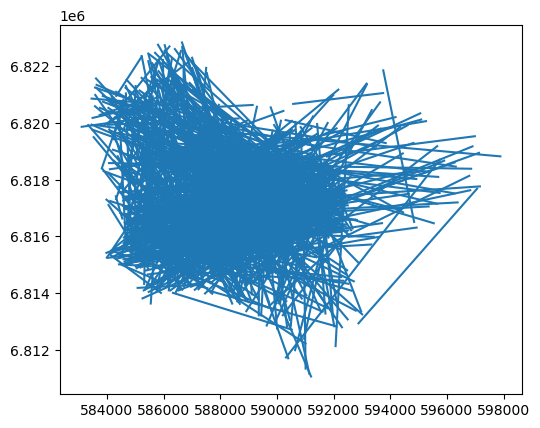

In [86]:
df_trips = df_trips.set_geometry("geometry")
df_trips.plot()

## Bonus Exercise 3.2: Routing (4 points)

In [87]:
osmosis_path = "osmosis-0.49.2/bin/osmosis"

# Test if osmosis can be called from the notebook
!{osmosis_path} -v

mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Searching for JPF plugins.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the core plugin.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the extension plugins.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Building tasks.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Connecting tasks.
mai 01, 2024 3:40:

In [88]:
study_area_df_iris_united.to_file("data/study_area.gpkg")

In [89]:
!{osmosis_path} --read-pbf data/centre-latest.osm.pbf \
    --tag-filter accept-ways highway=motorway,motorway_link,trunk,trunk_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential,residential_link \
    --bounding-polygon file=data/study_area.poly completeWays=yes \
    --used-node --write-xml data/study_area.osm.xml

mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Launching pipeline execution.
mai 01, 2024 3:40:21 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline executing, waiting for completion.
mai 01, 2024 3:41:27 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline complete.
mai 01, 2024 3:41:27 AM org.openstreetmap.osmosis.core.Osmosis run
INFO: Total execution time: 65604 milliseconds.


In [90]:
# With 'highway=*', we had the error 'zsh:1: no matches found: highway=*'
# But this still lead to a problem in the next cell with 'InsufficientResponseError: No data elements in server response.'
# Which lead to all the next cells not working

## Convert a road network from OpenStreetMap data such that you can use it for routing. Plot the network on a map of your study area. (2 points)

In [91]:
graph = ox.graph_from_xml("data/study_area.osm.xml")

InsufficientResponseError: No data elements in server response. Check query location/filters and log.

In [92]:
# Self-loop edges
self_loop_edges = list(nx.selfloop_edges(graph))
graph.remove_edges_from(self_loop_edges)

# Isolated nodes
graph = ox.utils_graph.remove_isolated_nodes(graph)

# Find strongly connected component
graph = ox.utils_graph.get_largest_component(graph, strongly = True)

# Speeds and travel times
graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

NameError: name 'graph' is not defined

In [93]:
df_edges = ox.graph_to_gdfs(graph, edges = True, nodes = False)
df_edges = df_edges.reset_index()[["u", "v", "highway", "geometry"]]
df_edges["highway"] = df_edges["highway"].astype(str)

NameError: name 'graph' is not defined

In [94]:
df_edges.to_file("study_area_network.gpkg")

df_edges.plot(figsize=(10, 10))
plt.show()

NameError: name 'df_edges' is not defined

In [95]:
# We have a problem at cell 82 that causes the graph to be not defined, so we can not plot the network

#### Perform a routing of all generated trips on the network. Count the number of trips traversing each edge of your network and indicate the flow on each link on a map. (2 points)

In [96]:
# add origin_node column to our data frame
geometry = df_trips["origin_geometry"].to_crs("EPSG:4326")
df_trips["origin_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

# add destination_node column to our data frame
geometry = df_trips["destination_geometry"].to_crs("EPSG:4326")
df_trips["destination_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

NameError: name 'graph' is not defined

In [97]:
N = len(df_trips)

routes = ox.shortest_path(
    graph, df_trips["origin_node"].iloc[:N], df_trips["destination_node"].iloc[:N], weight = "travel_time"
)

NameError: name 'graph' is not defined

In [98]:
df_count = { "u": [], "v": [] }

for route in routes:
    for k in range(1, len(route)):
        df_count["u"].append(route[k - 1])
        df_count["v"].append(route[k])

df_count = pd.DataFrame(df_count)
df_count = df_count.groupby(["u", "v"]).size().reset_index(name = "count")

df_count.sort_values(by = "count", ascending = False).head()

NameError: name 'routes' is not defined

In [99]:
df_count = pd.merge(df_edges, df_count, on = ["u", "v"])

NameError: name 'df_edges' is not defined

In [100]:
df_count.plot("count", legend = True)

AttributeError: 'dict' object has no attribute 'plot'